# <span style="color:coral"> <center> ConvNeXt with tensorflow</center> </span>

# <span >Notebook Overview</span>

* In this notebook I have implemented `ConvNext tiny` model from the research paper titled as [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545) using tensorflow.

* The code in this notebook is reusable and can be reused with any dataset of your choice.

* In this notebook I will train `ConvNext tiny` model from scratch on CIFAR-10 dataset.


In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

# <span style="color:coral">Loading Cifar10 Data</span>

In [2]:
# # importing Cifar10 data from keras datasets
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# # Normalize train and test images
# x_train, x_test = x_train / 255.0, x_test / 255.0 

import os
import pickle

# Path to the dataset
data_path = "/kaggle/input/1st-dataset/cifar-10-batches-py"

# Load a single batch
def load_cifar10_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data']
        labels = batch[b'labels']
        # Reshape images
        images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        labels = np.array(labels)
        return images, labels

# Load all training batches
x_train = []
y_train = []
for i in range(1, 6):
    file_path = os.path.join(data_path, f"data_batch_{i}")
    images, labels = load_cifar10_batch(file_path)
    x_train.append(images)
    y_train.append(labels)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

# Load test batch
x_test, y_test = load_cifar10_batch(os.path.join(data_path, "test_batch"))

# Normalize images
x_train = x_train / 255.0
x_test = x_test / 255.0

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3), y_train shape: (50000,)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000,)


I will be using `tf.data` api which helps to build flexible and efficient input pipeline.
​
td.data allows us to do various tasks in memory efficient way such as :
​
* `map()` - maps a predefined function to dataset
* `shuffle()` - randomly shuffles the elements of a target 
* `batch()` - turns dataset into batches 
* `prefetch()` - prepares subsequent batches of data while other batches of data are being computed

In [3]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE=128
# convert images to float32 format and convert labels to int32
def preprocess (image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

#Peform augmentations on training data
def augmentation(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    return image, label


train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#applying transformations 
train_data = train_data.shuffle(1024) # shuffle the images
train_data = train_data.map(preprocess, num_parallel_calls=AUTO)# mapping our preprocess function to train_data 
train_data = train_data.map(augmentation, num_parallel_calls=AUTO)# mapping our augmentation funtion to train_data
train_data = train_data.batch(BATCH_SIZE) #Converting train_data to batches
train_data = train_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.

# train_data = train_data.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))


test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#applying transformations 
test_data = test_data.map(preprocess, num_parallel_calls=AUTO) # mapping our preprocess function test_data 
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.


# <center>ConvNeXt Block</center>

For implementing `ConvNeXt` block authors take inspiration from the `ResNext` architecture which use [grouped convolutions](https://paperswithcode.com/method/grouped-convolution#:~:text=A%20Grouped%20Convolution%20uses%20a,level%20and%20high%20level%20features.), for `ConvNeXt` block authors utlize the combination of [depthwise convolutions](https://paperswithcode.com/method/depthwise-convolution) and 1x1 [point-wise convolutions](https://paperswithcode.com/method/pointwise-convolution). Depthwise convolutions reduce the number of parameters and computation used in convolutional operations while increasing representational efficiency. Pointwise convolutions is a 1x1 convolution which projects the channels output by the depthwise convolution onto a new channel space
 
In this paper authors use a slightly modified [inverted bottle-neck](https://paperswithcode.com/method/inverted-residual-block) design given by:

1. A depthwise convolution, authors found out that `7x7 size` depthwise convolution gives better performance than that of other sizes. followed by a layer norm normalization layer as used in transformer architectures.

2. `Layer normalization` is used after the depthwise convolution instead of the Batch Normalization. As opposed to ResNet Block architecture ConvNeXt block only uses `layer norm` once in a residual block. 

> `Note:` In batchnorm, the mean and variance used for normalization are calculated across all elements in a batch, for each feature independently while in layernorm, they are calculated across the feature dimension, for each element and instance independently. 

3. A 1x1 `pointwise convolution` is used after LN.

4. A [GELU](https://paperswithcode.com/method/gelu) activation function is used after 1x1 pointwise convolutional layer. As opposed to multiple ReLU activations in ResNet residual block, ConvNext uses GELU activation function only once in a residual block.

5. Another 1x1 `pointwise convolution` is used.

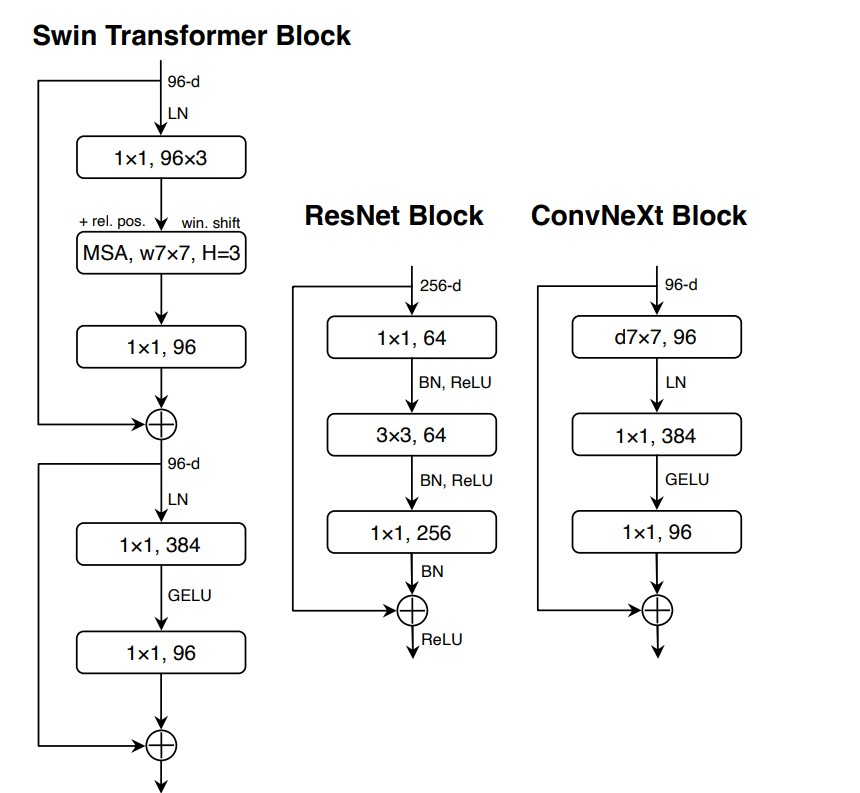

> Image source [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545) 

In [4]:
class ConvNext_Block(tf.keras.Model):
    
    """
    Implementing the ConvNeXt block for 
    
    Args:
        dim: No of input channels
        drop_path: stotchastic depth rate 
        layer_scale_init_value=1e-6
    
    Returns:
        A conv block
    """
    
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6, **kwargs):
        super(ConvNext_Block, self).__init__(**kwargs)
        
        self.depthwise_convolution = layers.Conv2D(dim, kernel_size=7, padding="same", groups=dim )
        self.layer_normalization = layers.LayerNormalization(epsilon=1e-6)
        self.pointwise_convolution_1 = layers.Dense(4 * dim)
        self.GELU = layers.Activation("gelu")
        self.pointwise_convolution_2 = layers.Dense(dim)
        self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,)))
        if drop_path>0.0:
            self.drop_path=(tfa.layers.StochasticDepth(drop_path))
        else:
            self.drop_path=layers.Activation("linear")
        

    def call(self, inputs):
        x = inputs
        x = self.depthwise_convolution(x)
        x = self.layer_normalization(x)
        x = self.pointwise_convolution_1(x)
        x = self.GELU(x)
        x = self.pointwise_convolution_2(x)
        x = self.gamma * x

        return inputs + self.drop_path(x)


# Patchify Stem 

For processing the input images, ConvNeXt utilizes patchify strategy of transformers by 4x4 convolutional layer with stride of 4 i.e it will have non overlapping patches.

In [5]:
def patchify_stem(dims):
    """
    Implements the stem block of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
    
    Returns:
        feature maps after patchify operation
    """
    stem = keras.Sequential(
        [layers.Conv2D(dims[0], kernel_size=4, strides=4),
        layers.LayerNormalization(epsilon=1e-6)],
        )
    return stem

# Spatial Downsampling

Similar to Resnets and Swin Transformer, ConvNext perform spatial downsampling with `2x2` conv layer having `stride` of **2**. Authors of the paper observed that adding Layer Normalization layer gives significantly good performance.



In [6]:
def spatial_downsampling(stem,dims,kernel_size,stride):
    """
    Implements Spatial Downsampling of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
        stem: Patchify stem output of images
        kernel_size: Downsampling kernel_size
        stride: Downsampling stride length
    Returns:
        Downsampled layers
    """

    ds_layers = []
    ds_layers.append(stem)
    for dim in dims[1:]:
        layer = keras.Sequential(
            [layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(dim, kernel_size=kernel_size, strides=stride),
            ]
        )
        ds_layers.append(layer)
        
    return ds_layers

# Convnext Stages
We will iteratively build the stages of ConvNeXt block by calling the ConvNext_Block function created earlier over the feature dimensions at each stage.

In [7]:
def ConvNext_Stages (dims,drop_path_rate,depths,layer_scale_init_value):
    """
    Creating stages each consiting of multiple residual blocks
    
    Args:
        dims: List of feature dimensions at each stage.
        drop_path_rate: Stochastic depth rate
        depths: Number of blocks at each stage
        layer_scale_init_value: Init value for Layer Scale
        
    """
    stages = []
    dropout_rates = [x for x in tf.linspace(0.0, drop_path_rate, sum(depths))]
    cur = 0
    for i in range(len(dims)):
        stage = keras.Sequential(
            [*[ConvNext_Block(dim=dims[i],drop_path=dropout_rates[cur + j],layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            ]
        )
        stages.append(stage)
        cur += depths[i]
    return stages

# Final ConvNeXt Model

In this implementaion I will be implementing the ConvNeXt-T having dimensions = (96, 192, 384, 768) and depths = (3, 3, 9, 3)

In [8]:
drop_path_rate=0.0
layer_scale_init_value=1e-6
dims=[1, 1, 1, 1]
depths=[3, 3, 9, 3]

In [9]:
inputs = layers.Input((32,32,3))
x = inputs

stem=patchify_stem(dims)

downsampling=spatial_downsampling(stem,dims,kernel_size=2,stride=2)

stages=ConvNext_Stages(dims,drop_path_rate,depths,layer_scale_init_value)

for i in range(len(stages)):
    x = downsampling[i](x)
    x = stages[i](x)

x = layers.GlobalAvgPool2D()(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)

outputs = layers.Dense(10)(x)

ConvNeXt_model=keras.Model(inputs, outputs)

In [10]:
ConvNeXt_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 8, 8, 1)           51        
_________________________________________________________________
sequential_4 (Sequential)    (None, 8, 8, 1)           198       
_________________________________________________________________
sequential_1 (Sequential)    (None, 4, 4, 1)           7         
_________________________________________________________________
sequential_5 (Sequential)    (None, 4, 4, 1)           198       
_________________________________________________________________
sequential_2 (Sequential)    (None, 2, 2, 1)           7         
_________________________________________________________________
sequential_6 (Sequential)    (None, 2, 2, 1)           594   

In [11]:
ConvNeXt_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001,weight_decay=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

history=ConvNeXt_model.fit(train_data,
          batch_size=64,
          epochs=25,
          validation_data=test_data)

Epoch 1/25
391/391 [==============================] - 44s 64ms/step - loss: 2.3027 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/25
391/391 [==============================] - 22s 56ms/step - loss: 2.3027 - accuracy: 0.0957 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/25
391/391 [==============================] - 21s 54ms/step - loss: 2.3027 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/25
391/391 [==============================] - 22s 57ms/step - loss: 2.3027 - accuracy: 0.0965 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/25
391/391 [==============================] - 22s 56ms/step - loss: 2.3027 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/25
391/391 [==============================] - 20s 52ms/step - loss: 2.3027 - accuracy: 0.0964 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/25
391/391 [==============================] - 21s 54ms/step - loss: 2.3027 - accuracy: 0.0958 - val_loss: 2.3026 - val_accuracy:

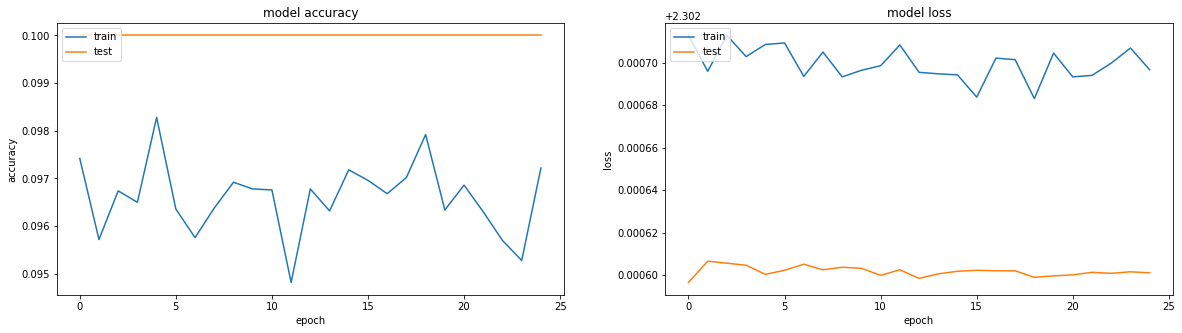

In [12]:
# Plotting loss and accuracy curves
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# References

* https://arxiv.org/abs/2201.03545

* https://github.com/facebookresearch/ConvNeXt

* https://arxiv.org/abs/1512.03385

* https://arxiv.org/abs/2103.14030

* https://arxiv.org/abs/1607.06450

* https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec

* https://paperswithcode.com/method/inverted-residual-block

* https://github.com/keras-team/keras/blob/master/keras/applications/convnext.py

* https://paperswithcode.com/method/gelu


# Citation
```bibtex
@Article{liu2022convnet,
  author  = {Zhuang Liu and Hanzi Mao and Chao-Yuan Wu and Christoph Feichtenhofer and Trevor Darrell and Saining Xie},
  title   = {A ConvNet for the 2020s},
  journal = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
  year    = {2022},
}
```